# Exploratory Data Analysis (EDA) — Reto Clasificación Médica Multilabel

## 1. Introducción

### Objetivo del EDA
Entender la distribución de los artículos médicos (títulos, abstracts, grupos) y detectar posibles retos (multi-label, desbalance, longitud de textos).

### Descripción breve del dataset
- **title:** Título del artículo médico.
- **abstract:** Resumen científico del artículo.
- **group:** Categoría(s) médica o grupo al que pertenece el artículo.

## 2. Carga y vista inicial

### Importamos librerías 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cargamos y revisamos los datos

In [ ]:
# Cargar los datos
df = pd.read_csv('../data/challenge_data-18-ago.csv', delimiter=';')

# Vista rápida de los datos
df.head(4)

,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological


: 

### Información básica del dataframe

In [16]:
# Revisamos los tipos de datos del DataFrame e identificamos los valores faltantes y tipos incorrectos.
df.info()
print(f'Número de filas duplicadas: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3565 non-null   object
 1   abstract  3565 non-null   object
 2   group     3565 non-null   object
dtypes: object(3)
memory usage: 83.7+ KB
Número de filas duplicadas: 0


### Detección de duplicados

In [17]:
df.duplicated(subset=['title']).sum()  # Revisamos duplicados basándonos en la columna 'title'
# Mostramos los valores duplicados de la columna 'title'
df[df.duplicated(subset=['title'], keep=False)].sort_values(by='title')

,title,abstract,group
2246,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
2261,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
1433,State-of-the-art thiazide diuretics for prosta...,Research question: How does beta-blockers affe...,hepatorenal
3096,State-of-the-art thiazide diuretics for prosta...,Background: cancer affects diabetic patients w...,cardiovascular


El artículo *"Long term hormone therapy for perimenopausal and postmenopausal women."* Aparece duplicado pero al leer el abstracto pudimos identificar que uno es una versión actualizada del otro.
> This is an updated version of the original Cochrane review first published in 2005.

## 3. Análisis de etiquetas multilabel

### 3.1 Distribución de frecuencia

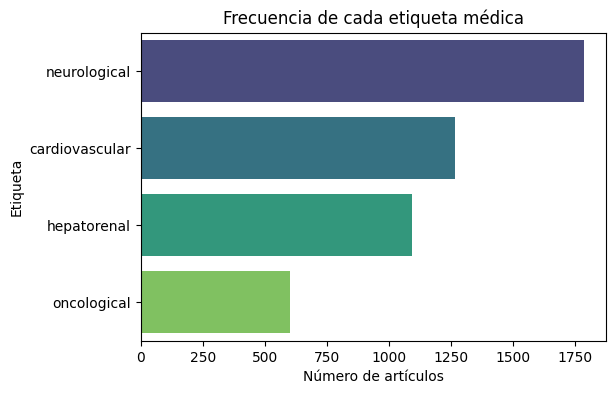

Estadísticas de etiquetas médicas:
                Count  Percentage
group                            
neurological     1785       50.07
cardiovascular   1268       35.57
hepatorenal      1091       30.60
oncological       601       16.86


In [261]:
# Expandir grupos (multi-label)
from collections import Counter

all_labels = [g for row in df['group'].dropna() for g in row.split('|')]
label_counts = Counter(all_labels)
#Ordenamos las etiquetas por frecuencia
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(6,4))
sns.barplot(y=list(label_counts.keys()), x=list(label_counts.values()), hue=list(label_counts.keys()), palette="viridis", legend=False)
plt.title("Frecuencia de cada etiqueta médica")
plt.ylabel("Etiqueta")
plt.xlabel("Número de artículos")
plt.show()

label_counts = df['group'].str.split('|').explode().value_counts()
label_stats = pd.DataFrame({
    'Count': label_counts,
    'Percentage': (label_counts / len(df) * 100).round(2)
})
print("Estadísticas de etiquetas médicas:")
print(label_stats)

#### Frecuencia de etiquetas múltiples

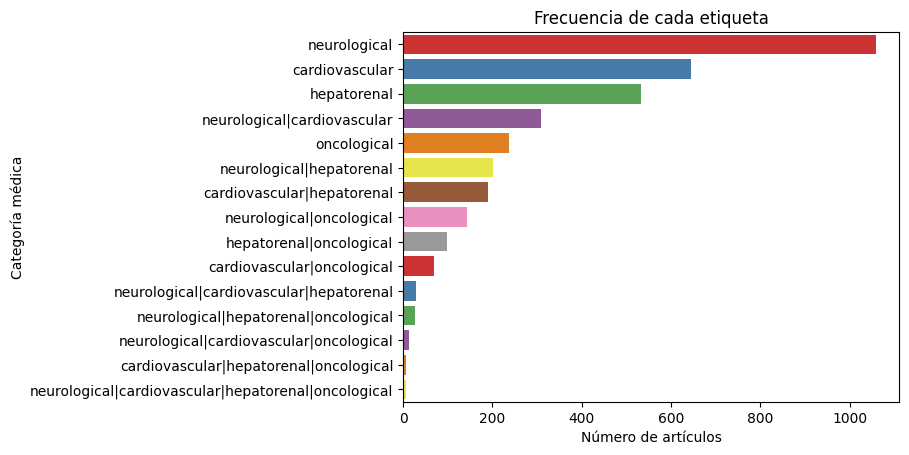

Estadísticas de etiquetas médicas:
                                                    Count  Percentage
neurological                                         1058       29.68
cardiovascular                                        645       18.09
hepatorenal                                           533       14.95
neurological|cardiovascular                           308        8.64
oncological                                           237        6.65
neurological|hepatorenal                              202        5.67
cardiovascular|hepatorenal                            190        5.33
neurological|oncological                              143        4.01
hepatorenal|oncological                                98        2.75
cardiovascular|oncological                             70        1.96
neurological|cardiovascular|hepatorenal                28        0.79
neurological|hepatorenal|oncological                   26        0.73
neurological|cardiovascular|oncological                

In [262]:
# Revisamos los valores únicos en la columna 'group'
label_counts = df["group"].str.get_dummies(sep=",").sum().sort_values(ascending=False)
sns.barplot(x=label_counts.values, y=label_counts.index, hue=label_counts.index, palette='Set1', legend=False)
plt.xlabel("Número de artículos")
plt.ylabel("Categoría médica")
plt.title("Frecuencia de cada etiqueta")
plt.show()

label_stats = pd.DataFrame({
    'Count': label_counts,
    'Percentage': (label_counts / len(df) * 100).round(2)
})
print("Estadísticas de etiquetas médicas:")
print(label_stats)

### 3.2 Número de etiquetas por artículo

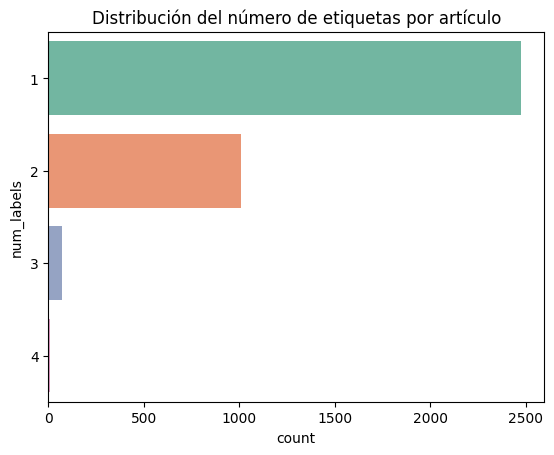

            Count  Percentage
num_labels                   
1            2473       69.37
2            1011       28.36
3              74        2.08
4               7        0.20


In [264]:
df['num_labels'] = df['group'].apply(lambda x: len(x.split('|')))
sns.countplot(data=df, y='num_labels', hue='num_labels', palette='Set2', legend=False)
plt.title("Distribución del número de etiquetas por artículo")
plt.show()

label_counts = df['num_labels'].value_counts()
label_stats = pd.DataFrame({
    'Count': label_counts,
    'Percentage': (label_counts / len(df) * 100).round(2)
})
print(label_stats)

### 3.3 Co-ocurrencia de etiquetas 

#### Mapa de calor con matriz de co-ocurrencia normalizada.
La normalización convierte los conteos absolutos en proporciones del total, haciendo comparable la fuerza de co-ocurrencia entre pares de etiquetas.

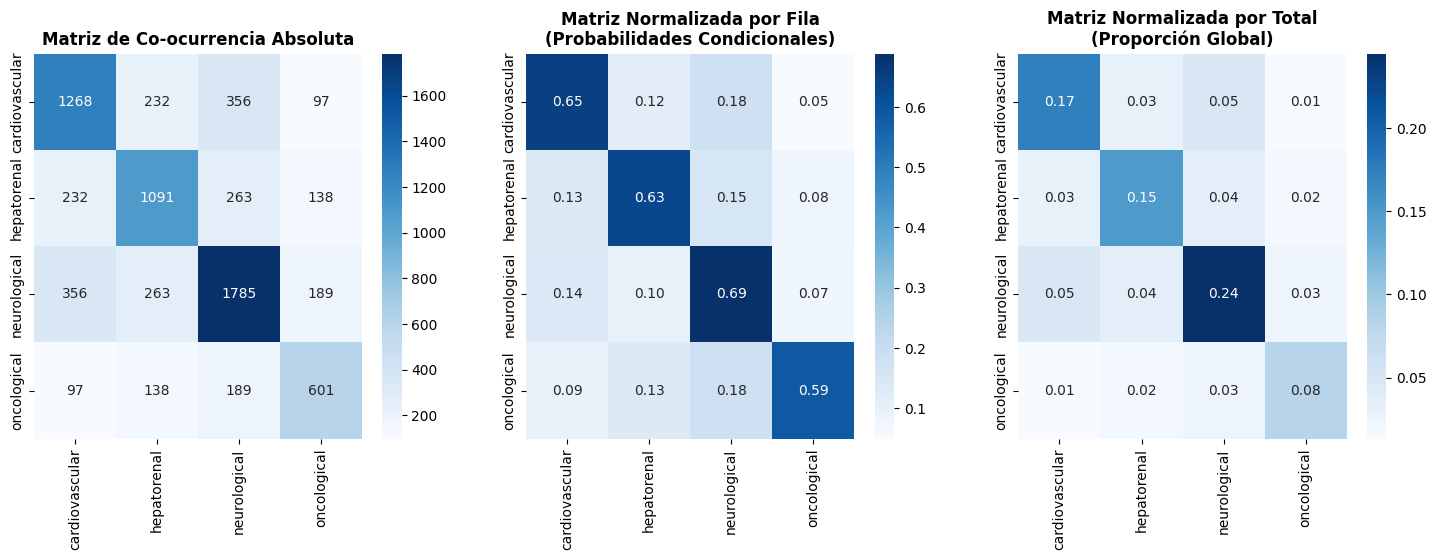

In [232]:
# One-hot encoding de etiquetas multilabel
label_dummies = df['group'].str.get_dummies(sep='|')

# Matriz de co-ocurrencia absoluta
co_matrix = label_dummies.T.dot(label_dummies)
# Normalización por fila

# Cada fila suma 1 - representa P(columna | fila)
co_norm_row = co_matrix.div(co_matrix.sum(axis=1), axis=0)

# Normalización por suma total (la que tenías antes)
co_norm_total = co_matrix / co_matrix.values.sum()

# Crear subplots para comparar ambas normalizaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Matriz absoluta
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Matriz de Co-ocurrencia Absoluta', fontsize=12, fontweight='bold')

# Subplot 2: Normalización por fila (CORRECTA para co-ocurrencia)
sns.heatmap(co_norm_row, annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
axes[1].set_title('Matriz Normalizada por Fila\n(Probabilidades Condicionales)', fontsize=12, fontweight='bold')

# Subplot 3: Normalización por total
sns.heatmap(co_norm_total, annot=True, fmt=".2f", cmap="Blues", ax=axes[2])
axes[2].set_title('Matriz Normalizada por Total\n(Proporción Global)', fontsize=12, fontweight='bold')

# plt.tight_layout()
plt.show()

La normalización por fila nos permite ver que cada celda ``[i,j]`` representa ``P(etiqueta_j | etiqueta_i)`` - la probabilidad condicional de que aparezca la etiqueta ``j`` dado que ya apareció ``i``. Ejemplo: ``cardiovascular → neurological = 0.182`` significa que el **18.2%** de documentos cardiovasculares también son neurológicos.

Una gran parte de los artículos con etiqueta "cardiovascular" también tienen etiqueta "neurological", lo que sugiere una interdependencia clínica (p. ej. *stroke* como condición neurológica con origen cardiovascular).

### 3.4 Correlación de etiquetas

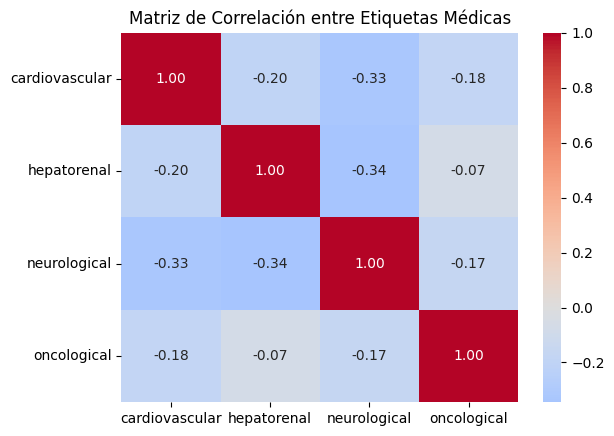

In [268]:
# correlación de etiquetas
label_corr = label_dummies.corr()
plt.figure()
sns.heatmap(label_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlación entre Etiquetas Médicas")
plt.show()

La matriz de correlación evidencia asociaciones relevantes entre etiquetas médicas, como la relación positiva entre neurológica y cardiovascular. Este tipo de análisis complementa la exploración de co-ocurrencias y permite justificar decisiones de preprocesamiento, como la agrupación de clases o el ajuste de umbrales en modelos multilabel. Se integra como parte del análisis exploratorio para fortalecer la interpretación clínica y técnica del dataset.


## 4. Análisis de textos

### 4.1 Longitud de los títulos y abstracts

#### Distribución (histogramas)

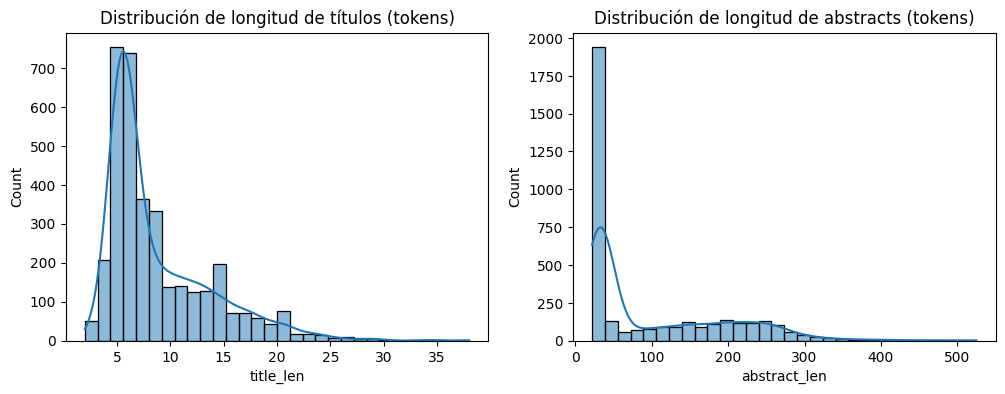

In [190]:
df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))
df['abstract_len'] = df['abstract'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['title_len'], bins=30, ax=axes[0], kde=True)
axes[0].set_title("Distribución de longitud de títulos (tokens)")

sns.histplot(df['abstract_len'], bins=30, ax=axes[1], kde=True)
axes[1].set_title("Distribución de longitud de abstracts (tokens)")

plt.show()


#### Métricas (media, mediana, desviaciones estándar)

In [238]:
# Medias y desviaciones estándar
print(f"Título: μ={df['title_len'].mean():.1f}, σ={df['title_len'].std():.1f}")
print(f"Abstract: μ={df['abstract_len'].mean():.1f}, σ={df['abstract_len'].std():.1f}")
print(f"Longitud ratio (abstract/título): {df['abstract_len'].mean()/df['title_len'].mean():.1f}")

# Mediana
print(f"\nMedianas:")
print(f"Título - Mediana: {df['title_len'].median():.1f}")
print(f"Abstract - Mediana: {df['abstract_len'].median():.1f}, \n")

desbalance = label_dummies.sum()
print("Desbalance etiquetas:", (desbalance/max(desbalance)).round(2).to_dict())

# Imbalance ratio
imbalance_ratio = desbalance.max() / desbalance.min()
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")

Título: μ=8.7, σ=4.9
Abstract: μ=100.1, σ=93.1
Longitud ratio (abstract/título): 11.5

Medianas:
Título - Mediana: 7.0
Abstract - Mediana: 37.0, 

Desbalance etiquetas: {'cardiovascular': 0.71, 'hepatorenal': 0.61, 'neurological': 1.0, 'oncological': 0.34}
Imbalance Ratio (IR): 2.97


- Los abstracts son en promedio 11.5x más largos que los títulos (100.1 vs 8.7 palabras).
- El desbalance máximo es de 3.0x entre la clase más frecuente (neurological) y menos frecuente (oncological).


#### Percentiles

In [199]:
# Percentiles de longitud de texto (título y abstract)
text_percentiles = pd.DataFrame({
    'title_len': [
        df['title_len'].quantile(q) for q in [0.25, 0.50, 0.75, 0.90, 0.95]
    ],
    'abstract_len': [
        df['abstract_len'].quantile(q) for q in [0.25, 0.50, 0.75, 0.90, 0.95]
    ]
}, index=['P25', 'P50', 'P75', 'P90', 'P95'])

print("Percentiles de longitud de texto:")
print(text_percentiles)

Percentiles de longitud de texto:
     title_len  abstract_len
P25        5.0          31.0
P50        7.0          37.0
P75       11.0         172.0
P90       16.0         246.0
P95       19.0         272.8


#### Visualizaciones: Boxplots por categoría

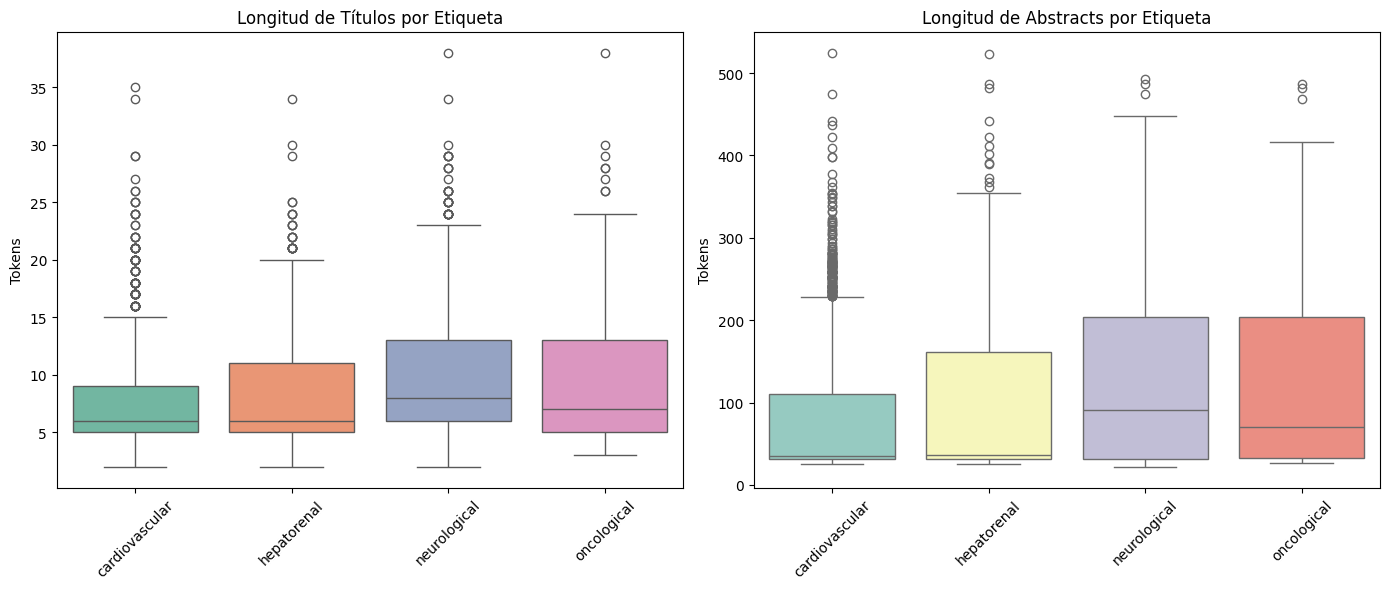

In [220]:
# Preparamos un DataFrame largo para graficar
df_len = pd.concat(
    [df[['title_len','abstract_len']], label_dummies],
    axis=1
).melt(
    id_vars=['title_len','abstract_len'],
    value_vars=label_dummies.columns,
    var_name='label',
    value_name='present'
)
df_len = df_len[df_len['present'] == 1] 

# Boxplots de longitud
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(x='label', y='title_len', data=df_len, hue='label', palette='Set2', legend=False)
plt.title('Longitud de Títulos por Etiqueta')
plt.xlabel('')
plt.ylabel('Tokens')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.boxplot(x='label', y='abstract_len', data=df_len, hue='label', palette='Set3', legend=False)
plt.title('Longitud de Abstracts por Etiqueta')
plt.xlabel('')
plt.ylabel('Tokens')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### Validamos textos cortos

In [123]:
# Cantidad de registros con longitud < 5 tokens
short_titles   = df[df['title_len']   < 5]
short_abstracts = df[df['abstract_len'] < 5]

print(f"Títulos con <5 tokens   : {len(short_titles)} ({len(short_titles)/len(df):.2%})")
print(f"Abstracts con <5 tokens : {len(short_abstracts)} ({len(short_abstracts)/len(df):.2%})")

Títulos con <5 tokens   : 258 (7.24%)
Abstracts con <5 tokens : 0 (0.00%)


## 5. Insights de lenguaje natural

### 5.1 Palabras más frecuentes

Limpiamos el texto de las stopwords para enfocarnos en palabras más significativas y lo normalizamos.

In [227]:
# Librerías para procesamiento de texto
# from collections import Counter # Ya importado arriba
import re
import nltk
from wordcloud import WordCloud

stopwords = set(nltk.corpus.stopwords.words("english"))

def clean_and_tokenize(text):
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return [t for t in tokens if t not in stopwords]

all_tokens = []
for text in df['abstract'].dropna():
    all_tokens.extend(clean_and_tokenize(text))

freqs = Counter(all_tokens).most_common(20)
pd.DataFrame(freqs, columns=["word","count"]).head(10)


,word,count
0,patients,4291
1,results,2626
2,methods,1927
3,study,1877
4,conclusion,1562
5,cancer,1520
6,1,1374
7,disease,1289
8,0,1247
9,treatment,1120


#### WordCloud ilustrativa de abstracts

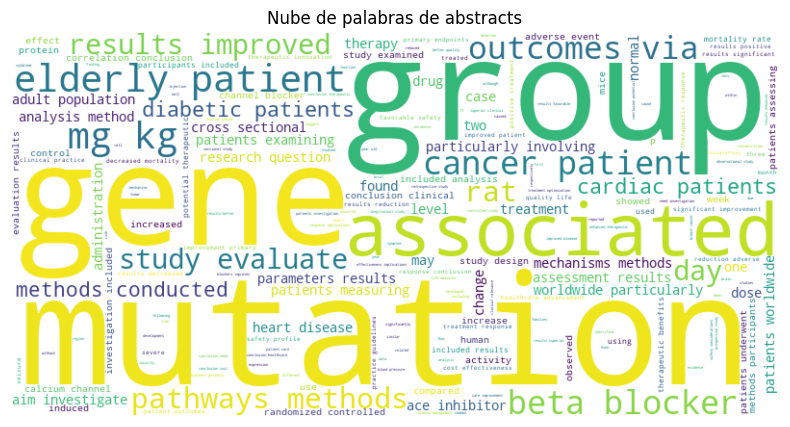

In [269]:
# WordCloud de abstracts
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_tokens))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de abstracts")
plt.show()

#### Top 10 bigramas

In [270]:
from sklearn.feature_extraction.text import CountVectorizer
# Top 10 n-grams (bigrams) en abstracts
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X_ngrams = vectorizer.fit_transform(df['abstract'].dropna())    
ngrams_freq = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
print(ngrams_freq.head(10))

elderly patients     465
mg kg                446
cancer patients      437
beta blockers        421
pathways methods     416
results improved     403
study evaluate       402
cardiac patients     396
diabetic patients    396
methods conducted    394
dtype: int64


### 5.2 Top terms por categoría TF-IDF 

#### Términos más característicos para cada grupo

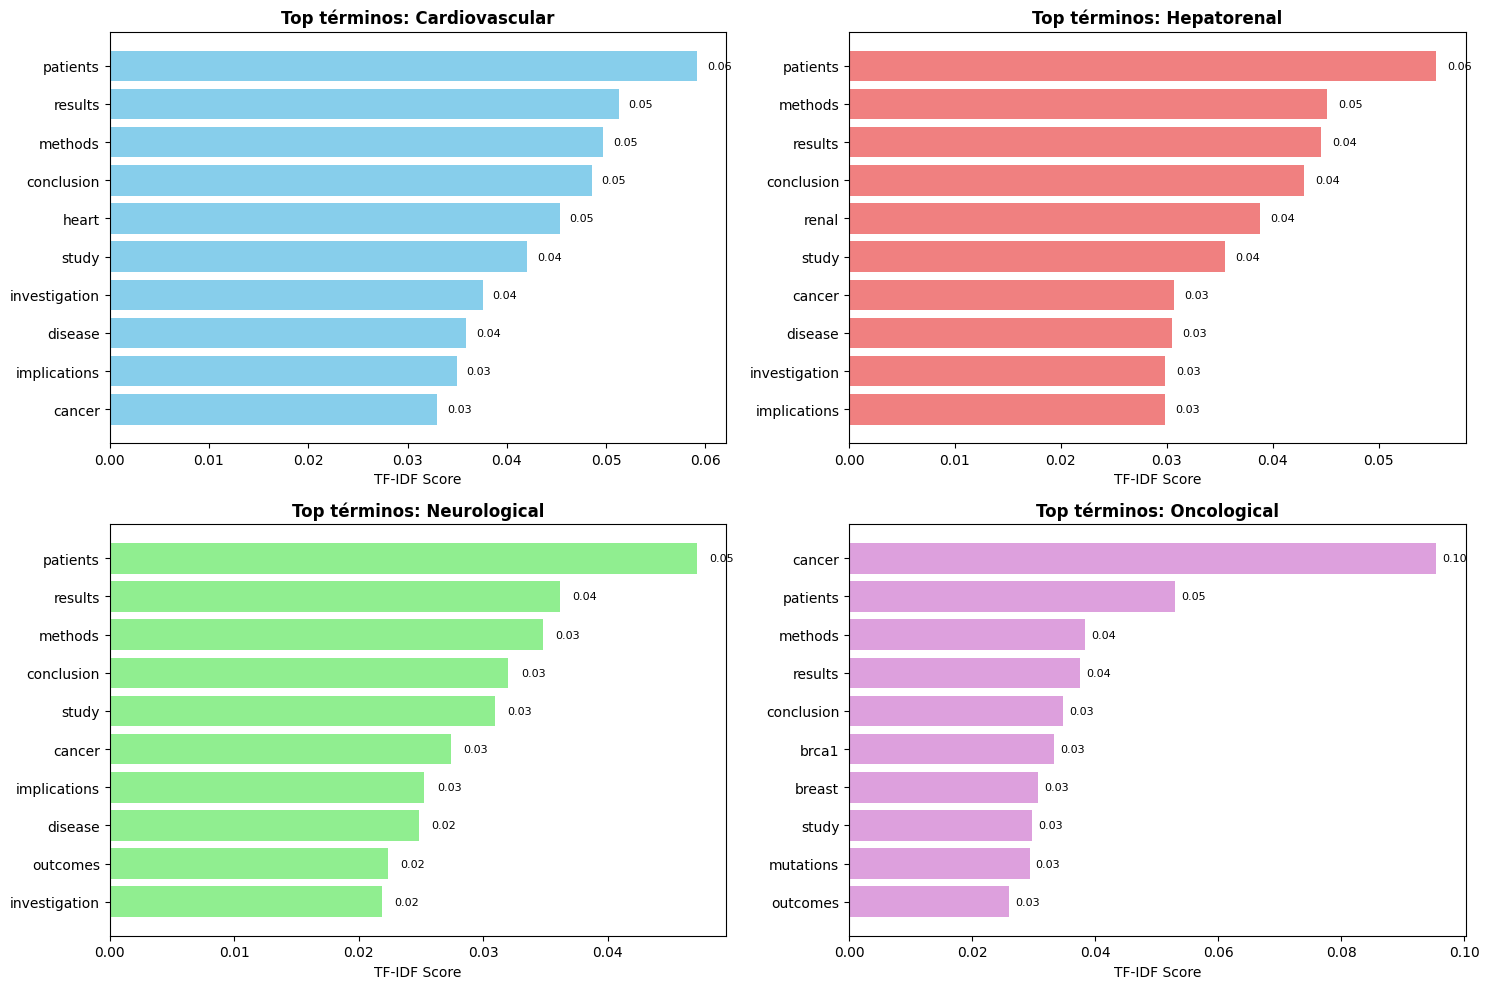

In [231]:
# Tu código TF-IDF existente (mantenerlo igual)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df['abstract'])

def top_terms_for_class(label, n=10):
    idx = df['group'].str.contains(label).values
    class_mean = X[idx].mean(axis=0).A1
    terms = np.array(tfidf.get_feature_names_out())
    top_idx = class_mean.argsort()[-n:][::-1]
    return list(zip(terms[top_idx], class_mean[top_idx]))

# REEMPLAZO: Gráfico facetado en lugar del barplot sobrecargado
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for i, label in enumerate(unique_labels):
    terms_scores = top_terms_for_class(label, 10)
    terms, scores = zip(*terms_scores)
    
    axes[i].barh(range(len(terms)), scores, color=colors[i])
    axes[i].set_yticks(range(len(terms)))
    axes[i].set_yticklabels(terms)
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_title(f'Top términos: {label.capitalize()}', fontweight='bold')
    axes[i].invert_yaxis()  # Términos más relevantes arriba
    
    # Añadir valores en las barras
    for j, score in enumerate(scores):
        axes[i].text(score + 0.001, j, f'{score:.2f}', 
                    va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [251]:
print("Vocab único abstracts:", len(tfidf.get_feature_names_out()))

Vocab único abstracts: 5000


#### Visualización por categoría

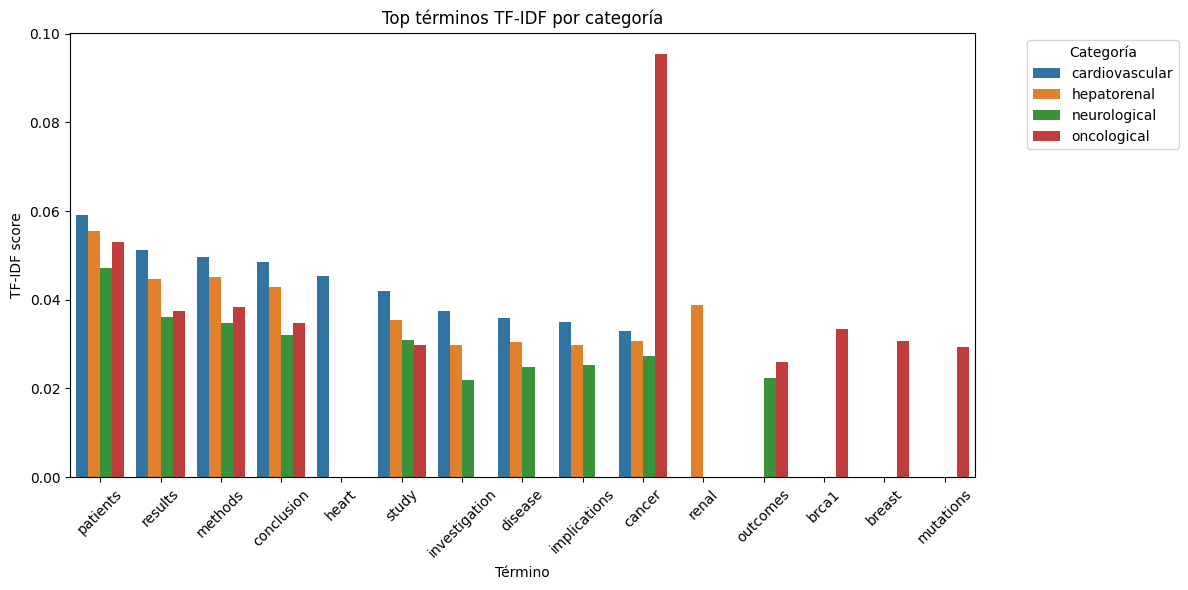

In [248]:
# Guardamos los resultados en un DataFrame
top_terms = []
for label in unique_labels:
    terms_scores = top_terms_for_class(label, 10)
    for term, score in terms_scores:
        top_terms.append({'label': label, 'term': term, 'score': score})

df_top_terms = pd.DataFrame(top_terms)

# Graficamos los términos más relevantes por categoría
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_top_terms,
    x='term', y='score', hue='label'
)
plt.title('Top términos TF-IDF por categoría')
plt.ylabel('TF-IDF score')
plt.xlabel('Término')
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Baselines y métricas simples

### Baseline Multilabel (Combinación más frecuente)

In [272]:
from collections import Counter

# Encontrar la combinación de etiquetas más frecuente
label_combinations = df['group'].value_counts()
most_frequent_combination = label_combinations.index[0]
most_frequent_count = label_combinations.iloc[0]

print("Baseline multilabel:")
print(f"Combinación más frecuente: '{most_frequent_combination}'")
print(f"Frecuencia: {most_frequent_count} documentos ({most_frequent_count/len(df)*100:.1f}%)")

# Accuracy de predecir siempre la combinación más frecuente
multilabel_baseline_acc = most_frequent_count / len(df)
print(f"Naïve baseline accuracy (multilabel): {multilabel_baseline_acc:.1%}")


Baseline multilabel:
Combinación más frecuente: 'neurological'
Frecuencia: 1058 documentos (29.7%)
Naïve baseline accuracy (multilabel): 29.7%


Este baseline representa un clasificador que siempre predice la combinación más común de etiquetas.

In [271]:
print(f"\nBaseline por etiqueta individual (predecir según frecuencia):")
individual_baselines = {}

for label in label_dummies.columns:
    # Frecuencia de la etiqueta
    label_freq = label_dummies[label].mean()
    
    # Baseline = predecir siempre la clase más frecuente
    baseline = max(label_freq, 1 - label_freq)
    
    individual_baselines[label] = baseline
    print(f"  {label}: {baseline:.1%} (predecir {'presente' if label_freq > 0.5 else 'ausente'})")

# Baseline promedio
avg_individual_baseline = np.mean(list(individual_baselines.values()))
print(f"\nBaseline promedio individual: {avg_individual_baseline:.1%}")



Baseline por etiqueta individual (predecir según frecuencia):
  cardiovascular: 64.4% (predecir ausente)
  hepatorenal: 69.4% (predecir ausente)
  neurological: 50.1% (predecir presente)
  oncological: 83.1% (predecir ausente)

Baseline promedio individual: 66.8%


Estos valores son los que debe superar el modelo para poder considerarlo útil.

## 7. Conclusiones del EDA
Con base en el análisis exploratorio, se tomaron decisiones clave para orientar el diseño del modelo y el pipeline de procesamiento.

### Resumen de hallazgos clave

- **Naturaleza del dataset:**  
  El conjunto contiene 3.565 artículos médicos con `title`, `abstract` y `group`. La columna `group` es **multi-label**, lo que significa que un mismo artículo puede pertenecer a más de una categoría médica.

- **Distribución de etiquetas:**  
  Las categorías están **desbalanceadas**: Neurological es la más frecuente (~50%) mientras que Oncological es la menor (~17%). El **imbalance ratio (IR)** entre la clase más y menos representada es ≈ *2.97*.  
  Además, ~30% de los artículos tienen más de una etiqueta (multietiquetado), lo cual aumenta la complejidad del problema.

- **Co-ocurrencia y correlación:**  
  Las matrices muestran correlaciones notables, por ejemplo (ejemplo: *cardiovascular ↔ neurological*). Esto indica que ciertas categorías tienden a presentarse juntas y que las etiquetas **no son independientes**.

- **Longitud de textos:**  
  - Los títulos son breves (mediana ≈ *7* tokens).  
  - Los abstracts son mucho más largos (mediana ≈ *37* tokens, con un P95 cercano a *272.8*).  
  - La relación promedio abstract/título es aproximadamente de *11.5* veces.  
  Este patrón justifica el uso de técnicas como **TF-IDF con bigramas** o **embeddings preentrenados** para capturar el contexto médico.

- **Insights de lenguaje natural:**  
  - Los términos más frecuentes en abstracts corresponden a terminología biomédica especializada.  
  - Los **TF-IDF top terms** permiten diferenciar semánticamente cada categoría (ej: “tumor” en Oncological, “neuron” en Neurological).  
  - Esto confirma que existen señales léxicas claras para la clasificación.

- **Baselines:**  
  - El baseline multilabel (predecir siempre la combinación más frecuente) alcanza una accuracy de ≈ *29.7%*.  
  - Los baselines por etiqueta individual oscilan entre ~*50.1%* y ~*83.1%*.  
  Esto establece un piso de referencia que cualquier modelo debe superar.

### Implicaciones para el modelado

1. **Métrica principal:** Utilizar *Weighted F1-score* para manejar el desbalance.  
2. **Preprocesamiento:** 
    - Se conservarán abstracts completos, aplicando truncado si se usan transformers, para capturar contexto sin desperdiciar memoria.
    - Se evitará una normalización agresiva para preservar la terminología médica.
    - Se mantendrán títulos cortos (<5 tokens), ya que los abstracts asociados contienen información valiosa. Eliminar estas filas implicaría perder el 7.24 % del corpus sin beneficio real
3. **Estrategia de modelado:**  
    - Enfoques **One-vs-Rest** (Logistic Regression, LinearSVC) como baseline sólido. 
    - Modelos basados en **embeddings biomédicos** (PubMedBERT, BioBERT) para mejorar separación semántica.  
    - Se utilizarán salidas con **sigmoides** para permitir predicciones multilabel independientes y calibración por clase.
4. **Desafío clave y soluciones:**
    - El desbalance de clases y la correlación entre etiquetas sugieren aplicar **pesos por clase** (``class_weight``) o técnicas de **oversampling**.
    - La alta co-ocurrencia entre etiquetas como *neurological* y *cardiovascular* (≈ 0.05) justifica calibrar umbrales de decisión por etiqueta. Implementaremos umbrales personalizados basados en F1-score por clase.
    - Se implementará un pipeline robusto y modular que permita:
        - Eliminación de *stopwords* específicas del dominio médico (palabras comunes pero poco informativas como “patient”, “study”).
        - Lematización contextualizada para mejorar la calidad semántica de las features.
        - Flexibilidad para adaptar el pipeline a distintos modelos y métricas.

### Conclusión general
El EDA confirma que el problema es un reto de **clasificación multilabel desbalanceada en lenguaje biomédico**. Las características del dataset (longitud de abstracts, co-ocurrencia de etiquetas, señales léxicas) respaldan un pipeline basado en NLP moderno (TF-IDF + modelos lineales como baseline, y embeddings especializados como mejora). El siguiente paso es implementar y evaluar estos modelos, comparando su rendimiento contra los baselines establecidos.